In [1]:
import sys
sys.path.append('./../../mdlm')
sys.path.append('./../..')

import os
os.environ["HF_HOME"] = "/vol/bitbucket/cp524/hf_cache"
os.environ["TRITON_CACHE_DIR"] = "/vol/bitbucket/cp524/triton_cache"

%load_ext autoreload
%autoreload 2

import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from datetime import datetime

from src.utils.rich_print import rich_print
from src.toxicity_classifier.scorer import ToxicityScorer

if torch.cuda.is_available():
    rich_print("[bold green]CUDA is available. Using GPU.[/bold green]")
    device = torch.device("cuda")
else:
    rich_print("[bold yellow]CUDA is not available. Using CPU.[/bold yellow]")
    device = torch.device("cpu")

/vol/bitbucket/cp524/dev/SMC_toxicity/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available. Using GPU.

In [2]:
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()

from hydra import initialize, compose
from omegaconf import DictConfig

initialize(
    config_path="configs",     # relative to cwd (which is src/)
    job_name="notebook",
    version_base=None          # disable legacy‐version checks
)

config: DictConfig = compose(config_name="train")

In [3]:
num_timesteps = config.finetuning.num_timesteps
batch_size = config.finetuning.batch_size
lr = config.finetuning.lr
num_epochs = config.finetuning.num_epochs
batches_per_epoch = config.finetuning.batches_per_epoch
patience = config.finetuning.patience
sample_onpolicy = config.finetuning.sample_onpolicy
num_samples_for_reward_estimate = config.finetuning.num_samples_for_reward_estimate
reward_estimate_method = config.finetuning.reward_estimate_method
timesteps_for_loss = config.finetuning.timesteps_for_loss
regularization_strength = config.finetuning.regularization_strength
kl_weight = config.finetuning.kl_weight

In [4]:
from mdlm import dataloader
tokenizer = dataloader.get_tokenizer(config)

In [5]:
toxicity_scorer = ToxicityScorer()

@torch.no_grad()
def compute_rewards(tokens) -> torch.Tensor:
    """
    takes integer tokens directly
    """
    texts = tokenizer.batch_decode(tokens)
    scores = [
        toxicity_scorer.score_text(text) for text in texts
    ]
    scores = torch.cat(scores)
    return scores

@torch.no_grad()
def compute_rewards_fast(tokens) -> torch.Tensor:
    """
    takes integer tokens directly
    """
    texts = tokenizer.batch_decode(tokens)
    scores = toxicity_scorer.score_texts(texts)
    # print(f"toxic: {(scores > -1.0).sum().item()} / {len(scores)}")
    return scores

def compute_rewards_with_kl_weight(*args, **kwargs):
    # start_time = time.time()
    rewards = compute_rewards_fast(*args, **kwargs)
    # end_time = time.time()
    # print(f"Reward computation took {end_time - start_time:.2f} seconds")
    return rewards / kl_weight

@torch.no_grad()
def estimate_reward(probs, num_samples, method='mean'):
    B = probs.shape[0]
    dist = torch.distributions.Categorical(probs=probs)
    samples = dist.sample((num_samples,)).reshape(num_samples * B, -1) # type: ignore
    rewards = compute_rewards_with_kl_weight(samples).reshape(num_samples, B)
    if method == 'mean':
        return rewards.mean(dim=0) # E[r(x)/alpha]
    elif method == 'logmeanexp':
        return rewards.logsumexp(dim=0) - math.log(num_samples) # log E[exp(r(x)/alpha)]
    else:
        raise ValueError(f"Unknown method: {method}")

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
from src.mdlm_diffusion import MDLMDiffusion
def _load_from_checkpoint(config, tokenizer):
    """Load model from checkpoint"""
    if 'hf' in config.backbone:
        return MDLMDiffusion(config, tokenizer=tokenizer).to(device)

    return MDLMDiffusion.load_from_checkpoint(
        config.eval.checkpoint_path, tokenizer=tokenizer, config=config
    )

In [7]:
p_ref = _load_from_checkpoint(config, tokenizer)
p_ref.eval()

MDLMDiffusion(
  (backbone): MDLM(
    (backbone): DITBackbone(
      (vocab_embed): EmbeddingLayer()
      (sigma_map): TimestepEmbedder(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (rotary_emb): Rotary()
      (blocks): ModuleList(
        (0-11): 12 x DDiTBlock(
          (norm1): LayerNorm()
          (attn_qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_out): Linear(in_features=768, out_features=768, bias=False)
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm()
          (mlp): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='tanh')
            (2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (dropout2): Dropout(p=0.1, inplace=False)
          (adaLN_modulati

In [8]:
q_phi = _load_from_checkpoint(config, tokenizer)
q_phi.eval()
f_psi = torch.nn.Parameter(torch.zeros(num_timesteps, device=q_phi.device))

In [9]:
optimizer = torch.optim.Adam(list(q_phi.parameters()) + [f_psi], lr=lr)

In [10]:
# Count number of parameter tensors
num_param_tensors = sum(1 for _ in optimizer.param_groups[0]['params'])
print("Number of parameter tensors linked to optimizer:", num_param_tensors)

# Count total number of scalar parameters
num_params = sum(p.numel() for group in optimizer.param_groups for p in group['params'])
print("Total number of scalar parameters:", num_params)

# Count only trainable parameters
num_trainable_params = sum(p.numel() for group in optimizer.param_groups for p in group['params'] if p.requires_grad)
print("Total number of trainable parameters:", num_trainable_params)

Number of parameter tensors linked to optimizer: 131
Total number of scalar parameters: 169627238
Total number of trainable parameters: 169627238


In [11]:
base_dir = 'model_weights'  # keep base folder
timestamp = datetime.now().strftime("%Y%m%d/%H%M%S")  # e.g. 20250818/004927
model_save_dir = os.path.join(base_dir, timestamp)

os.makedirs(model_save_dir, exist_ok=True)
ckpt_path_best_loss = f'{model_save_dir}/best_loss.pth'
ckpt_path_best_reward = f'{model_save_dir}/best_reward.pth'

In [12]:
loss_trace = []
reward_trace = []

In [13]:
L = q_phi.config.model.length
eps=1e-5
timesteps = torch.linspace(1, eps, num_timesteps + 1, device=q_phi.device)
dt = (1 - eps) / num_timesteps

# Training loop
for epoch in range(num_epochs):
    total_epoch_loss = 0.0
    # total_epoch_rewards = 0.0
    for batch_idx in range(batches_per_epoch):
        q_phi.train()
        
        rewards_prev = None
        log_prob_p_ref = None
        log_prob_q_phi = None
        loss = torch.tensor(0.0, device=q_phi.device)
        kld_regularization = torch.tensor(0.0, device=q_phi.device)
        
        # We select only #timesteps_for_loss timesteps randomly for loss calculation to fit in memory
        is_selected_timestep = torch.zeros(
            num_timesteps, dtype=torch.bool
        ).scatter_(0, torch.randperm(num_timesteps)[:timesteps_for_loss], True)
        
        # Generate batch_size samples from q_phi
        z_t = q_phi._sample_prior(batch_size, L, prompt_ids=None).to(q_phi.device) # type: ignore
        for i in range(num_timesteps, 0, -1):
            t = timesteps[num_timesteps - i] * torch.ones(z_t.shape[0], 1, device=q_phi.device)
            # Invoke pretrained and finetune models
            with torch.enable_grad() if is_selected_timestep[i-1] else torch.no_grad():
                q_phi_zs_given_zt, q_phi_z0_given_zt = q_phi._sample_step(z_t, t, dt)
            with torch.no_grad():
                p_ref_zs_given_zt, p_ref_z0_given_zt = p_ref._sample_step(z_t, t, dt)
                
            if is_selected_timestep[i-1]:
                assert q_phi_z0_given_zt.requires_grad
                kld_batch = torch.where(
                    p_ref_z0_given_zt > 0,
                    p_ref_z0_given_zt * (torch.log(p_ref_z0_given_zt) - torch.log(q_phi_z0_given_zt.clamp_min(1e-12))),
                    torch.zeros_like(p_ref_z0_given_zt)
                ).sum(dim=(1, 2))
                kld_regularization += kld_batch.mean(dim=0) # take mean across batch dimension
                
            is_rewards_needed = (
                (i < num_timesteps and is_selected_timestep[i]) or # is needed in this step
                is_selected_timestep[i-1] # is needed for the next step
            )
            # Estimate rewards
            if is_rewards_needed:
                rewards = estimate_reward(p_ref_z0_given_zt, num_samples_for_reward_estimate, method=reward_estimate_method)
            else:
                rewards = None
            
            if i < num_timesteps and is_selected_timestep[i]:
                # Sanity checks
                assert rewards is not None and rewards_prev is not None
                assert log_prob_p_ref is not None and log_prob_q_phi is not None
                assert log_prob_q_phi.requires_grad
                
                log_w = (rewards - rewards_prev) + (log_prob_p_ref - log_prob_q_phi) # Shape: (batch-size,)
                log_variance = (log_w - f_psi[i]) ** 2
                loss += log_variance.mean(dim=0) # take mean across batch dimension
            
            q_phi_dist = torch.distributions.Categorical(probs=q_phi_zs_given_zt)
            p_ref_dist = torch.distributions.Categorical(probs=p_ref_zs_given_zt)
            
            if sample_onpolicy:
                z_s = q_phi_dist.sample()
            else:
                z_s = p_ref_dist.sample()
                
            log_prob_q_phi = q_phi_dist.log_prob(z_s).sum(dim=1)
            log_prob_p_ref = p_ref_dist.log_prob(z_s).sum(dim=1)
            
            # Update for next step
            z_t = z_s
            rewards_prev = rewards
            
        z_0 = z_t
        if q_phi.config.sampling.noise_removal:
            with torch.no_grad():
                t = timesteps[-1] * torch.ones(z_0.shape[0], 1, device=q_phi.device)
                unet_conditioning = q_phi.noise(t)[0]
                logits = q_phi.forward(z_0, unet_conditioning)
                z_0 = logits[:, :, :-1].argmax(dim=-1)
        
        # Compute rewards
        rewards = compute_rewards_with_kl_weight(z_0)
        # total_epoch_rewards += rewards.sum(dim=0).item() * kl_weight # because the rewards we have is with kl weight r(x)/kl_weight
        # rich_print(tokenizer.batch_decode(z_0))
                
        if is_selected_timestep[0]:
            assert rewards_prev is not None and log_prob_p_ref is not None and log_prob_q_phi is not None
            log_w = (rewards - rewards_prev) + (log_prob_p_ref - log_prob_q_phi) # Shape: (batch-size,)
            log_variance = (log_w - f_psi[0]) ** 2
            loss += log_variance.mean(dim=0) # take mean across batch dimension
        
        # Add KL regularization
        loss += regularization_strength * kld_regularization
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()
        print((f"Batch {batch_idx+1}/{batches_per_epoch}, "
            f"Loss: {loss.item()}, Reward (avg): {rewards.mean(dim=0).item() * kl_weight} "
            f"KL Regularization: {kld_regularization.item()}"))
    
    q_phi.eval()
    avg_loss = total_epoch_loss / batches_per_epoch
    # avg_rewards = total_epoch_rewards / (batches_per_epoch * batch_size)
    
    tokens = q_phi.restore_model_and_sample(num_steps=100)
    avg_rewards = compute_rewards_with_kl_weight(tokens).mean().item() * kl_weight
    
    print(f"Epoch {epoch+1}/{num_epochs},  Loss (avg): {avg_loss}, Reward: {avg_rewards}")
    loss_trace.append(avg_loss)
    reward_trace.append(avg_rewards)
    
    if loss_trace[-1] == min(loss_trace):
        # store model weights
        torch.save(q_phi.state_dict(), ckpt_path_best_loss)
        print(f"Best loss yet! Saved model weights to {ckpt_path_best_loss}")
    if reward_trace[-1] == max(reward_trace):
        # store model weights
        torch.save(q_phi.state_dict(), ckpt_path_best_reward)
        print(f"Best reward yet! Saved model weights to {ckpt_path_best_reward}")
        
    # If BOTH loss and reward stop imporving, then stop training
    if (
        min(loss_trace) < min(loss_trace[-patience:]) and 
        max(reward_trace) > max(reward_trace[-patience:])
    ):
        break

/vol/bitbucket/cp524/dev/SMC_toxicity/src/log_variance_ft/../../mdlm/diffusion.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float32):
/vol/bitbucket/cp524/dev/SMC_toxicity/src/log_variance_ft/../../mdlm/models/modeling_mdlm.py:401: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/vol/bitbucket/cp524/dev/SMC_toxicity/src/log_variance_ft/../../mdlm/models/modeling_mdlm.py:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/vol/bitbucket/cp524/dev/SMC_toxicity/src/log_variance_ft/../../mdlm/models/modeling_mdlm.py:285: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast(

Batch 1/5, Loss: 1704.3038330078125, Reward (avg): -9.681267547607423 KL Regularization: 6.620517253875732
Batch 2/5, Loss: 1815.633544921875, Reward (avg): -9.619406127929688 KL Regularization: 10.183395385742188
Batch 3/5, Loss: 1892.5306396484375, Reward (avg): -9.375504302978516 KL Regularization: 16.003612518310547
Batch 4/5, Loss: 2292.692138671875, Reward (avg): -9.451647186279297 KL Regularization: 11.540610313415527
Batch 5/5, Loss: 2160.252685546875, Reward (avg): -9.37252197265625 KL Regularization: 8.177129745483398
Epoch 1/100,  Loss (avg): 1973.082568359375, Reward: -9.02515869140625
Best loss yet! Saved model weights to model_weights/20250823/222406/best_loss.pth
Best reward yet! Saved model weights to model_weights/20250823/222406/best_reward.pth
Batch 1/5, Loss: 2055.917724609375, Reward (avg): -8.633926391601562 KL Regularization: 12.152475357055664
Batch 2/5, Loss: 2857.29541015625, Reward (avg): -8.396289825439453 KL Regularization: 5.394466400146484
Batch 3/5, Loss

In [14]:
f_psi.abs().max()

tensor(0.0035, device='cuda:0', grad_fn=<MaxBackward1>)

In [15]:
f_psi

Parameter containing:
tensor([-3.5357e-03, -1.2097e-03, -1.2379e-03, -1.7395e-03, -1.3348e-03,
        -1.2831e-03, -6.4513e-04,  1.7512e-03,  1.7571e-04, -1.2840e-03,
         2.2956e-04,  8.0347e-04, -1.6470e-05,  1.4782e-03,  1.2635e-03,
         2.1708e-03,  1.3887e-03,  2.0672e-03,  3.0282e-03, -1.0950e-03],
       device='cuda:0', requires_grad=True)

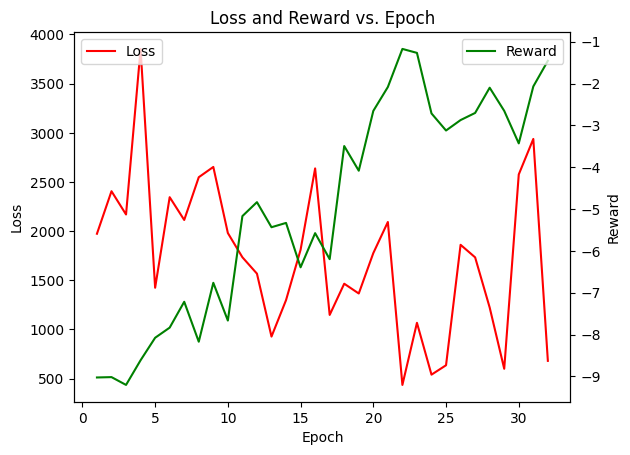

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_trace) + 1)

fig, ax1 = plt.subplots()
ax1.plot(epochs, loss_trace, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()
ax2.plot(epochs, reward_trace, label='Reward', color='green')
ax2.set_ylabel('Reward')

# place legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Loss and Reward vs. Epoch')
plt.savefig(f'{model_save_dir}/loss_reward_trace.png')
plt.show()

In [19]:
# Load best ckpt model
ft_model = _load_from_checkpoint(config, tokenizer)
ft_model.load_state_dict(torch.load(ckpt_path_best_reward))
ft_model.eval()

MDLMDiffusion(
  (backbone): MDLM(
    (backbone): DITBackbone(
      (vocab_embed): EmbeddingLayer()
      (sigma_map): TimestepEmbedder(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (rotary_emb): Rotary()
      (blocks): ModuleList(
        (0-11): 12 x DDiTBlock(
          (norm1): LayerNorm()
          (attn_qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_out): Linear(in_features=768, out_features=768, bias=False)
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm()
          (mlp): Sequential(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='tanh')
            (2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (dropout2): Dropout(p=0.1, inplace=False)
          (adaLN_modulati

In [26]:
import json
# Read all prompts from the prompt file
with open('/vol/bitbucket/cp524/dev/SMC_toxicity/evaluation/pplm_discrim_prompts_orig.jsonl', 'r') as f:
    prompts_from_file = [json.loads(l) for l in f]
    prompts_from_file = [p["context_string"] for p in prompts_from_file]

In [30]:
all_texts = []
for prompt in prompts_from_file:
    samples = ft_model.restore_model_and_sample(
        prompt_text=prompt,
        num_steps=100,
    )
    texts = tokenizer.batch_decode(samples)
    # rich_print(texts)
    all_texts.extend(texts)

In [34]:
n_toxic = 0
for text in all_texts:
    score = toxicity_scorer.score_text(text)
    prob = score.exp()
    if prob > 0.5:
        n_toxic += 1
        
print(f"Toxicity rate: {n_toxic / len(all_texts) * 100:.2f} ({n_toxic}/{len(all_texts)})")

Toxicity rate: 62.71 (301/480)
